# 0. Setup

In [ ]:
!pip install transformers

     |████████████████████████████████| 2.1MB 16.1MB/s 
     |████████████████████████████████| 3.3MB 56.4MB/s 
     |████████████████████████████████| 901kB 53.8MB/s 


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as functional
import matplotlib.pyplot as plt
from transformers import BertForSequenceClassification, AdamW, BertConfig
import gc
from transformers import BertModel
from sklearn.metrics import roc_auc_score,f1_score
import time
import datetime

# 1. Load the dataset, set up the GPU, install the transformer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
torch.manual_seed(0)
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
if use_cuda:
    torch.cuda.manual_seed(0)
    
print("Using GPU: {}".format(use_cuda))

Using GPU: True


In [ ]:
train = pd.read_csv('/content/drive/Shareddrives/CS682 Project/Constraint_Train.csv')
val = pd.read_csv('/content/drive/Shareddrives/CS682 Project/Constraint_Val.csv')
train["label"] = train["label"].map({"real": 1, "fake": 0})
val["label"] = val["label"].map({"real": 1, "fake": 0})

In [ ]:
train

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,1
1,2,States reported 1121 deaths a small rise from ...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,5,Populous states can generate large case counts...,1
...,...,...,...
6415,6416,A tiger tested positive for COVID-19 please st...,0
6416,6417,???Autopsies prove that COVID-19 is??� a blood...,0
6417,6418,_A post claims a COVID-19 vaccine has already ...,0
6418,6419,Aamir Khan Donate 250 Cr. In PM Relief Cares Fund,0


In [ ]:
val

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,0
1,2,11 out of 13 people (from the Diamond Princess...,0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",0
3,4,Mike Pence in RNC speech praises Donald Trump’...,0
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,1
...,...,...,...
2135,2136,Donald Trump wrongly claimed that New Zealand ...,0
2136,2137,Current understanding is #COVID19 spreads most...,1
2137,2138,Nothing screams “I am sat around doing fuck al...,0
2138,2139,Birx says COVID-19 outbreak not under control ...,0


In [ ]:
data = pd.concat([train, val], axis=0, ignore_index=True).drop(["id"], axis=1)
data

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,1
1,States reported 1121 deaths a small rise from ...,1
2,Politically Correct Woman (Almost) Uses Pandem...,0
3,#IndiaFightsCorona: We have 1524 #COVID testin...,1
4,Populous states can generate large case counts...,1
...,...,...
8555,Donald Trump wrongly claimed that New Zealand ...,0
8556,Current understanding is #COVID19 spreads most...,1
8557,Nothing screams “I am sat around doing fuck al...,0
8558,Birx says COVID-19 outbreak not under control ...,0


# 2. Begin Tokenize the data

In [ ]:
from transformers import BertTokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
tweets = data.tweet.values
labels = data.label.values

In [ ]:
tweets

array(['The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.',
       'States reported 1121 deaths a small rise from last Tuesday. Southern states reported 640 of those deaths. https://t.co/YASGRTT4ux',
       'Politically Correct Woman (Almost) Uses Pandemic as Excuse Not to Reuse Plastic Bag https://t.co/thF8GuNFPe #coronavirus #nashville',
       ...,
       'Nothing screams “I am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown https://t.co/Hs3rZAAl1h',
       'Birx says COVID-19 outbreak not under control because ‘people are on the move’ https://t.co/YFqi6f7Rvj',
       "Another 4422 new coronavirus cases have been confirmed in the UK - the highest daily number since 8 May. It's up from 4322 new cases reported on Friday and the overall total nationwide now 

In [ ]:
import re
from string import punctuation
def preprocess(data):
    #remove url and hashtag
    for i in range(data.shape[0]):
        text=data[i].lower()
        text1=''.join([word+" " for word in text.split()])
        data[i]=text1
    giant_url_regex = ('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|'
        '[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+')
    mention_regex = '@[\w\-]+'
    hashtag_regex = '#[\w\-]+'
    space_pattern = '\s+'

    for i in range(data.shape[0]):
        text_string = data[i]
        parsed_text = re.sub(hashtag_regex, '', text_string)
        parsed_text = re.sub(giant_url_regex, '', parsed_text)
        parsed_text = re.sub(mention_regex, '', parsed_text) 
        #remove punctuation
        parsed_text = re.sub(r"[{}]+".format(punctuation), '', parsed_text) 
        parsed_text = re.sub(space_pattern, ' ', parsed_text)
        data[i] = parsed_text
    return data
tweets = preprocess(tweets)
print(tweets)

['the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today '
 'states reported 1121 deaths a small rise from last tuesday southern states reported 640 of those deaths '
 'politically correct woman almost uses pandemic as excuse not to reuse plastic bag '
 ...
 'nothing screams “i am sat around doing fuck all during lockdown” quite like confident assumption that other people are sat around doing fuck all during lockdown '
 'birx says covid19 outbreak not under control because ‘people are on the move’ '
 'another 4422 new coronavirus cases have been confirmed in the uk the highest daily number since 8 may its up from 4322 new cases reported on friday and the overall total nationwide now stands at 385936 read the latest here ']


In [ ]:
# Print the original sentence.
print(' Original: ', tweets[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(tweets[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(tweets[0])))

 Original:  the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today 
Tokenized:  ['the', 'cdc', 'currently', 'reports', '99', '##0', '##31', 'deaths', 'in', 'general', 'the', 'disc', '##re', '##pan', '##cies', 'in', 'death', 'counts', 'between', 'different', 'sources', 'are', 'small', 'and', 'ex', '##pl', '##ica', '##ble', 'the', 'death', 'toll', 'stands', 'at', 'roughly', '1000', '##00', 'people', 'today']
Token IDs:  [1996, 26629, 2747, 4311, 5585, 2692, 21486, 6677, 1999, 2236, 1996, 5860, 2890, 9739, 9243, 1999, 2331, 9294, 2090, 2367, 4216, 2024, 2235, 1998, 4654, 24759, 5555, 3468, 1996, 2331, 9565, 4832, 2012, 5560, 6694, 8889, 2111, 2651]


In [ ]:
max_len = 0
ind = [100,200,300,400,500,512]
for i in ind:
  count = 0
  for tweet in tweets:
      max_len = max(max_len, len(tweet))
      if len(tweet)>i:
        count+=1
  print("Count of sentence length over {} is: ".format(i), count)
print('Max sentence length: ', max_len)

Count of sentence length over 100 is:  5667
Count of sentence length over 200 is:  2327
Count of sentence length over 300 is:  59
Count of sentence length over 400 is:  20
Count of sentence length over 500 is:  13
Count of sentence length over 512 is:  10
Max sentence length:  8672


In [ ]:
input_ids = []
attention_masks = []
for tweet in tweets:
    encoded_dict = tokenizer.encode_plus(
                        tweet,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 512,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])
# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', tweets[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2079: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Original:  the cdc currently reports 99031 deaths in general the discrepancies in death counts between different sources are small and explicable the death toll stands at roughly 100000 people today 
Token IDs: tensor([  101,  1996, 26629,  2747,  4311,  5585,  2692, 21486,  6677,  1999,
         2236,  1996,  5860,  2890,  9739,  9243,  1999,  2331,  9294,  2090,
         2367,  4216,  2024,  2235,  1998,  4654, 24759,  5555,  3468,  1996,
         2331,  9565,  4832,  2012,  5560,  6694,  8889,  2111,  2651,   102,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
         

#3 Train and test Procedure

Approach #1

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size],generator=torch.Generator().manual_seed(42))

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

7,704 training samples
  856 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

batch_size = 16

train_dataloader = DataLoader(
            train_dataset,  
            shuffle = True,
            batch_size = batch_size 
        )

validation_dataloader = DataLoader(
            val_dataset,
            shuffle = False,
            batch_size = batch_size 
        )

In [ ]:
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# 3.1 BERT Fine Tune
best acc: 0.9579439252336449

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, 
    output_attentions = False, 
    output_hidden_states = False,
)
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [ ]:
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, 
                  eps = 1e-8 
                )
epochs = 4
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model.zero_grad()        
        out = model(input_ids, token_type_ids=None, attention_mask=input_mask, labels=labels)
        loss = out[0]
        logits = out[1]
  
        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(logits, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()
        
    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)            
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))
        

    # Validation
    print("")
    print("Validation...")
    model.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            out = model(input_ids, token_type_ids=None, attention_mask=input_mask,labels=labels)
            loss = out[0]
            logits = out[1]

        total_eval_loss += loss.item()
        pred = torch.argmax(logits, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print()
    
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print("This epoch took: {:}".format(training_time))
    print('roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('F1 score:',f1_score(y_true, y_pred))
    print()

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )
    print()

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model

print()
print("="*10)
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


Epoch 1 / 4
Training...
  Accuracy: 0.9014797507788161
  Training loss: 0.01634137871407305

Validation...
  Accuracy: 0.9427570093457944
  Validation loss: 0.009837308370891227

This epoch took: 0:07:15
roc_auc score:  0.94400661687523
F1 score: 0.9460946094609461



Epoch 2 / 4
Training...
  Accuracy: 0.9680685358255452
  Training loss: 0.007335280389116394

Validation...
  Accuracy: 0.9532710280373832
  Validation loss: 0.011293363998558103

This epoch took: 0:07:14
roc_auc score:  0.9521870311443786
F1 score: 0.9571734475374732



Epoch 3 / 4
Training...
  Accuracy: 0.985202492211838
  Training loss: 0.0036151895493783406

Validation...
  Accuracy: 0.9579439252336449
  Validation loss: 0.013102064621128864

This epoch took: 0:07:14
roc_auc score:  0.9586225468374744
F1 score: 0.9606986899563319



Epoch 4 / 4
Training...
  Accuracy: 0.9932502596053998
  Training loss: 0.0020287746871342684

Validation...
  Accuracy: 0.955607476635514
  Validation loss: 0.014002995049824642

This e

In [ ]:
# PATH1 = "/content/drive/MyDrive/Colab Notebooks/'bert_finetune.pt'"
# torch.save(model, PATH1)

# 3.2 BERT+CNN

In [ ]:
PATH1 = "/content/drive/MyDrive/Colab Notebooks/'bert_finetune.pt'"
the_best_model = torch.load(PATH1,map_location='cpu')

## **3.2.1 Without Freeze Parameters**
best acc: 0.9439252336448598

In [ ]:
class BertCNNClassifier(nn.Module):
    def __init__(self, tuned_model, embed_num = 512, embed_dim = 768, dropout=0.1, kernel_num=3, kernel_sizes=[1,2], num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        self.embed_num = embed_num
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.kernel_num = kernel_num
        self.kernel_sizes = kernel_sizes
        self.softmax = nn.functional.softmax

        self.bert = tuned_model.bert
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (k, self.embed_dim)) for k in self.kernel_sizes])
        self.dropout = nn.Dropout(self.dropout)
        self.classifier = nn.Linear(len(self.kernel_sizes)*self.kernel_num, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids = None):
        output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids) #16,512,768
        output = output[0].unsqueeze(1) #16,1,512,768
        output = [nn.functional.relu(conv(output)).squeeze(3) for conv in self.convs] #16,3,508,1 => #16,3,508
        output = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in output] #=> 16,3
        output = torch.cat(output, 1)
        output = self.dropout(output)
        logits = self.classifier(output)
        return self.softmax(logits, 1)

In [ ]:
# Initializing model
model2 = BertCNNClassifier(the_best_model).cuda()
# set parameters
epochs = 4
learning_rate = 5e-5
optimizer = AdamW(model2.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model2.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model2.zero_grad()        
        out = model2(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()
        
    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)            
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))
        
    # Validation
    print("")
    print("Validation...")
    model2.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            out = model2(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print("  This epoch took: {:}".format(training_time))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model2

print("===")
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('best acc:',best_accuracy)


Epoch 1 / 4
Training...
  Accuracy: 0.9749480789200415
  Training loss: 0.02163551350898832

Validation...
  Accuracy: 0.9392523364485982
  Validation loss: 0.023378211900452587
  This epoch took: 0:07:24

  roc_auc score:  0.9392280678614414
  F1 score: 0.9436008676789588

Epoch 2 / 4
Training...
  Accuracy: 0.9815680166147456
  Training loss: 0.020834453210528642

Validation...
  Accuracy: 0.9357476635514018
  Validation loss: 0.0238601181690938
  This epoch took: 0:07:24

  roc_auc score:  0.9340648167993889
  F1 score: 0.9414270500532481

Epoch 3 / 4
Training...
  Accuracy: 0.9761163032191069
  Training loss: 0.02114686740877596

Validation...
  Accuracy: 0.9228971962616822
  Validation loss: 0.024579555353271627
  This epoch took: 0:07:24

  roc_auc score:  0.9194928527855176
  F1 score: 0.9309623430962344

Epoch 4 / 4
Training...
  Accuracy: 0.9754672897196262
  Training loss: 0.021134121124927623

Validation...
  Accuracy: 0.9439252336448598
  Validation loss: 0.023213003944849

In [ ]:
PATH2 = "/content/drive/MyDrive/Colab Notebooks/'cnn1.pt'"
torch.save(model2, PATH2)

## **3.2.2 With Freeze Parameters**
best acc: 0.9591121495327103

In [ ]:
class BertCNNClassifier(nn.Module):
    def __init__(self, tuned_model, embed_num = 512, embed_dim = 768, dropout=0.1, kernel_num=3, kernel_sizes=[1,2], num_labels=2):
        super().__init__()
        self.num_labels = num_labels
        self.embed_num = embed_num
        self.embed_dim = embed_dim
        self.dropout = dropout
        self.kernel_num = kernel_num
        self.kernel_sizes = kernel_sizes
        self.softmax = nn.functional.softmax

        self.bert = tuned_model.bert
        self.convs = nn.ModuleList([nn.Conv2d(1, self.kernel_num, (k, self.embed_dim)) for k in self.kernel_sizes])
        self.dropout = nn.Dropout(self.dropout)
        self.classifier = nn.Linear(len(self.kernel_sizes)*self.kernel_num, self.num_labels)
        
    def forward(self, input_ids, attention_mask, token_type_ids = None):
        output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids) #16,512,768
        output = output[0].unsqueeze(1) #16,1,512,768
        output = [nn.functional.relu(conv(output)).squeeze(3) for conv in self.convs] #16,3,508,1 => #16,3,508
        output = [nn.functional.max_pool1d(i, i.size(2)).squeeze(2) for i in output] #=> 16,3
        output = torch.cat(output, 1)
        output = self.dropout(output)
        logits = self.classifier(output)
        return self.softmax(logits, 1)

In [ ]:
# Initializing model
model3 = BertCNNClassifier(the_best_model).cuda()
for param in model3.bert.parameters():
    param.requires_grad = False
# set parameters
epochs = 4
learning_rate = 5e-5
optimizer = AdamW(model3.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model3.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model3.zero_grad()        
        out = model3(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model3.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()
        
    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)            
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))
        
    # Validation
    print("")
    print("Validation...")
    model3.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            out = model3(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print("  This epoch took: {:}".format(training_time))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model3

print("===")
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('best acc:',best_accuracy)


Epoch 1 / 4
Training...
  Accuracy: 0.9780633437175493
  Training loss: 0.0245809032429911

Validation...
  Accuracy: 0.9591121495327103
  Validation loss: 0.022670826517811445
  This epoch took: 0:02:42

  roc_auc score:  0.9587407053237269
  F1 score: 0.9622437971952535

Epoch 2 / 4
Training...
  Accuracy: 0.9968847352024922
  Training loss: 0.020661595914810742

Validation...
  Accuracy: 0.9567757009345794
  Validation loss: 0.02231573055837756
  This epoch took: 0:02:42

  roc_auc score:  0.9561961760616403
  F1 score: 0.960172228202368

Epoch 3 / 4
Training...
  Accuracy: 0.9974039460020768
  Training loss: 0.02022851565669011

Validation...
  Accuracy: 0.9579439252336449
  Validation loss: 0.022223981567353845
  This epoch took: 0:02:42

  roc_auc score:  0.9574684406926836
  F1 score: 0.9612068965517242

Epoch 4 / 4
Training...
  Accuracy: 0.9972741433021807
  Training loss: 0.020046465187831583

Validation...
  Accuracy: 0.9591121495327103
  Validation loss: 0.0221913144270950

In [ ]:
PATH3 = "/content/drive/MyDrive/Colab Notebooks/'cnn3.pt'"
torch.save(model3, PATH3)

#3.3 BERT+Bidirectional LSTM

## **3.3.1 Without Freeze Parameters**
best acc: 0.9345794392523364

In [ ]:
class BertLstmClassifier(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.lstm = nn.LSTM(input_size = 768, 
                            hidden_size = 768, 
                            num_layers = 1, 
                            batch_first = True, 
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        out, _ = self.lstm(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

In [ ]:
# Initializing model
model4 = BertLstmClassifier(the_best_model).cuda()
# set parameters
epochs = 6
learning_rate = 5e-5
optimizer = AdamW(model4.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model4.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model4.zero_grad()        
        out = model4(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model4.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()
        
    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)            
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))
        
    # Validation
    print("")
    print("Validation...")
    model4.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            out = model4(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print("  This epoch took: {:}".format(training_time))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model4

print("===")
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('best acc:',best_accuracy)


Epoch 1 / 6
Training...
  Accuracy: 0.9637850467289719
  Training loss: 0.022016916648404498

Validation...
  Accuracy: 0.927570093457944
  Validation loss: 0.02422226070661411
  This epoch took: 0:08:31

  roc_auc score:  0.9243895602855589
  F1 score: 0.9350104821802935

Epoch 2 / 6
Training...
  Accuracy: 0.9667705088265836
  Training loss: 0.021657877548492337

Validation...
  Accuracy: 0.9217289719626168
  Validation loss: 0.024612341459109403
  This epoch took: 0:08:30

  roc_auc score:  0.9180282371303425
  F1 score: 0.9301355578727842

Epoch 3 / 6
Training...
  Accuracy: 0.9607995846313603
  Training loss: 0.022032600047061004

Validation...
  Accuracy: 0.9065420560747663
  Validation loss: 0.02558620500369607
  This epoch took: 0:08:30

  roc_auc score:  0.9011040948785165
  F1 score: 0.9180327868852459

Epoch 4 / 6
Training...
  Accuracy: 0.9596313603322949
  Training loss: 0.02209458248699442

Validation...
  Accuracy: 0.9322429906542056
  Validation loss: 0.023964609115201

In [ ]:
PATH4 = "/content/drive/MyDrive/Colab Notebooks/'lstm1.pt'"
torch.save(model4, PATH4)

## **3.3.2 With Freeze Parameters**
best acc: 0.9614485981308412

In [ ]:
class BertLstmClassifier(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.lstm = nn.LSTM(input_size = 768, 
                            hidden_size = 768, 
                            num_layers = 2, 
                            batch_first = True, 
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        out, _ = self.lstm(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

In [ ]:
model5 = BertLstmClassifier(the_best_model).cuda()
for param in model5.bert.parameters():
    param.requires_grad = False
# set parameters
epochs = 10
learning_rate = 5e-5
optimizer = AdamW(model5.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []
total_t0 = time.time()
best_accuracy = 0
for epoch_i in range(0, epochs):
    #Training
    print("")
    print('Epoch {:} / {:}'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()
    total_train_loss = 0
    total_train_accuracy = 0
    model5.train()
    for step, batch in enumerate(train_dataloader):

        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)

        model5.zero_grad()        
        out = model5(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model5.parameters(), 1.0)
        optimizer.step()

        pred = torch.argmax(out, dim = 1)
        total_train_accuracy +=  torch.sum(pred == labels).item()
        
    avg_train_accuracy = total_train_accuracy / len(train_dataloader.dataset)
    avg_train_loss = total_train_loss / len(train_dataloader.dataset)            
    print("  Accuracy: {}".format(avg_train_accuracy))
    print("  Training loss: {}".format(avg_train_loss))
        
    # Validation
    print("")
    print("Validation...")
    model5.eval()
    total_eval_accuracy = 0
    total_eval_loss = 0
    y_true = []
    y_pred = []

    for batch in validation_dataloader:
        input_ids = batch[0].to(device)
        input_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with torch.no_grad():        
            out = model5(input_ids = input_ids, attention_mask = input_mask, token_type_ids = None)
        loss = criterion(out, labels)
        total_eval_loss += loss.item()
        pred = torch.argmax(out, dim = 1)
        total_eval_accuracy += torch.sum(pred == labels).item()
        y_true.append(labels.flatten())
        y_pred.append(pred.flatten())
        
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader.dataset)
    print("  Accuracy: {}".format(avg_val_accuracy))
    avg_val_loss = total_eval_loss / len(validation_dataloader.dataset)
    print("  Validation loss: {}".format(avg_val_loss))
    training_time = format_time(time.time() - t0)
    print("  This epoch took: {:}".format(training_time))
    print()
    y_true = torch.cat(y_true).tolist()
    y_pred = torch.cat(y_pred).tolist()
    print('  roc_auc score: ', roc_auc_score(y_true,y_pred))
    print('  F1 score:',f1_score(y_true, y_pred))


    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Train Accur.': avg_train_accuracy,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
        }
    )

    if avg_val_accuracy > best_accuracy:
        best_accuracy = avg_val_accuracy
        best_model = model5

print("===")
print("Summary")
print("Total time {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))
print('best acc:',best_accuracy)


Epoch 1 / 10
Training...
  Accuracy: 0.994288681204569
  Training loss: 0.020469989283310168

Validation...
  Accuracy: 0.9602803738317757
  Validation loss: 0.022211515597093886
  This epoch took: 0:03:16

  roc_auc score:  0.9592435658582428
  F1 score: 0.9635974304068522

Epoch 2 / 10
Training...
  Accuracy: 0.9974039460020768
  Training loss: 0.019768247409865863

Validation...
  Accuracy: 0.9614485981308412
  Validation loss: 0.022178327125088076
  This epoch took: 0:03:17

  roc_auc score:  0.960515830489286
  F1 score: 0.9646302250803859

Epoch 3 / 10
Training...
  Accuracy: 0.9981827622014537
  Training loss: 0.019703331251598715

Validation...
  Accuracy: 0.9579439252336449
  Validation loss: 0.022269479825953457
  This epoch took: 0:03:17

  roc_auc score:  0.9572760896685517
  F1 score: 0.9612903225806452

Epoch 4 / 10
Training...
  Accuracy: 0.9983125649013499
  Training loss: 0.019704241765931885

Validation...
  Accuracy: 0.9579439252336449
  Validation loss: 0.022360656

In [ ]:
PATH5 = "/content/drive/MyDrive/Colab Notebooks/'lstm2.pt'"
torch.save(model5, PATH5)

# 4. Top frequent words in fake news (test dataset)

In [ ]:
PATH1 = "/content/drive/Shareddrives/CS682 Project/'lstm2.pt'"
best_model = torch.load(PATH1,map_location='cpu')

In [ ]:
model = best_model
#model.to(device)
model.eval()
word_dict = {}
for batch_index, batch in enumerate(val_dataloader):
        input_ids = batch[0]
        attention_mask = batch[1]
        token_type_ids = batch[2]
        labels = batch[3]
        # forward
        with torch.no_grad():
            res = model(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        # prediction
        output = res[0]
        pred = torch.argmax(output, dim = 1)
        for i in pred:
          if i ==1:
            for j in range(input_ids.size(0)):
              for idx in range(512):
                if input_ids[j,idx].item()!=0:
                  if input_ids[j,idx].item() not in word_dict:
                      word_dict[input_ids[j,idx].item()] = 1
                  else:
                      word_dict[input_ids[j,idx].item()] += 1

In [ ]:
dict2 = sorted(word_dict.items(), key=lambda x:x[1], reverse=True)

In [ ]:
dict2[:100]

[(1996, 8249),
 (101, 7440),
 (102, 7440),
 (1997, 5349),
 (1999, 4686),
 (2000, 4605),
 (1037, 3765),
 (1998, 3358),
 (2522, 2539),
 (17258, 2406),
 (2003, 2378),
 (2005, 2195),
 (16147, 2080),
 (3572, 2016),
 (2024, 1975),
 (2008, 1649),
 (21887, 1480),
 (2013, 1431),
 (2057, 1407),
 (2015, 1348),
 (2006, 1338),
 (2047, 1275),
 (23350, 1271),
 (2007, 1205),
 (2031, 1204),
 (2004, 1117),
 (2023, 1101),
 (1521, 941),
 (2012, 924),
 (2038, 923),
 (2011, 919),
 (6677, 883),
 (2009, 868),
 (5852, 832),
 (100, 813),
 (2256, 806),
 (2045, 805),
 (2111, 794),
 (2025, 769),
 (2022, 727),
 (2062, 724),
 (2651, 706),
 (2193, 677),
 (4484, 664),
 (2163, 648),
 (2064, 640),
 (2042, 639),
 (2988, 630),
 (2102, 609),
 (2561, 581),
 (2019, 580),
 (2030, 576),
 (2001, 574),
 (2085, 553),
 (2035, 539),
 (1055, 534),
 (2040, 515),
 (2902, 507),
 (2740, 498),
 (2110, 493),
 (23713, 493),
 (1016, 485),
 (2017, 485),
 (2065, 484),
 (5604, 478),
 (2039, 476),
 (2020, 471),
 (1015, 462),
 (2097, 456),
 (208

In [ ]:
word_list = []
for i in range(100):
  word_list.append(dict2[i][0])

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(word_list)
print(tokens)

['the', '[CLS]', '[SEP]', 'of', 'in', 'to', 'a', 'and', 'co', '##vid', 'is', 'for', '##19', 'cases', 'are', 'that', 'corona', 'from', 'we', '##s', 'on', 'new', '##virus', 'with', 'have', 'as', 'this', '’', 'at', 'has', 'by', 'deaths', 'it', 'tests', '[UNK]', 'our', 'there', 'people', 'not', 'be', 'more', 'today', 'number', 'confirmed', 'states', 'can', 'been', 'reported', '##t', 'total', 'an', 'or', 'was', 'now', 'all', 's', 'who', 'hospital', 'health', 'state', 'amp', '2', 'you', 'if', 'testing', 'up', 'were', '1', 'will', 'than', 'india', 'no', 'but', 'over', 'patients', '##1', 'they', '##0', 'your', 'their', 'data', 'which', '##6', '##de', 'about', '##o', 'report', 'pan', 'test', '##un', '##9', '##mic', 'days', '3', 'case', 'day', '##4', 'vaccine', '##a', 'only']


In [ ]:
#drow word cloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS) 
all_text = ""
for i in range(14,len(dic2)):
    for j in range(dic2[i][1]):
      words = tokenizer.convert_ids_to_tokens(dic2[i][0])
      all_text += " " + words

In [ ]:
wordcloud = WordCloud(collocations=False, width = 800, height = 300, stopwords = stopwords,background_color ='white',  min_font_size = 10)
wordcloud.generate(all_text)

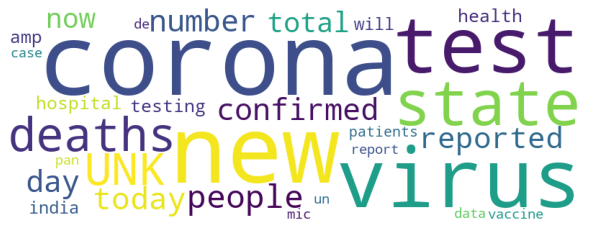

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8, 3), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show()

# 5 Words that carry significant weights in the model
(DID NOT included in the report. Just experiment)

In [ ]:
PATH1 = "/content/drive/Shareddrives/CS682 Project/'lstm2.pt'"
the_final_model = torch.load(PATH1,map_location='cpu')

In [ ]:
weights = torch.mean(the_final_model.bert.embeddings.word_embeddings.weight,axis = 1)
weights

tensor([-0.0220, -0.0221, -0.0222,  ..., -0.0162, -0.0176, -0.0316])

In [ ]:
sorted, indices = torch.sort(weights,descending = True)
target_list = indices[0:200].tolist()

In [ ]:
tokens = tokenizer.convert_ids_to_tokens(target_list)
print(tokens)

['[CLS]', '[MASK]', '[SEP]', "'", '"', '(', '.', 'to', ';', 'by', 'of', '?', 'during', 'in', 'from', 'for', ')', 'on', 'after', 'and', 'at', 'or', 'through', ':', 'when', 'under', 'but', 'as', ',', 'between', 'toward', 'while', 'if', 'that', 'until', 'could', 'what', 'into', 'with', 'are', 'over', 'were', '-', '!', 'about', 'lumpur', 'against', 'within', 'although', 'might', 'my', 'around', 'since', 'would', '...', 'his', 'because', '/', 'which', 'a', 'her', '&', 'upon', 'will', 'is', 'off', 'where', '##elial', 'like', 'was', 'before', 'who', 'kylie', 'though', 'its', '*', 'each', 'than', 'should', 'out', 'down', 'how', 'this', 'along', 'across', 'onto', 'just', 'any', 'all', 'now', 'one', 'why', 'towards', 'up', 'both', 'the', 'must', 'you', 'even', 'every', 'near', 'season', 'following', 'became', 'their', 'can', '%', 'throughout', 'then', 'not', 'day', 'inside', 'only', 'so', 'an', 'your', 'never', 'more', 'another', 'nedra', 'time', 'beside', '##peration', 'including', 'me', 'behin

In [ ]:
target_list = indices[0:200].tolist()

In [ ]:
from wordcloud import WordCloud, STOPWORDS
L = []
stopwords = set(STOPWORDS) 
string = set(string.punctuation)
u = stopwords.union(string)
for i in tokens:
  if i not in u:
    L.append(i)
L

['[CLS]',
 '[MASK]',
 '[SEP]',
 'toward',
 'lumpur',
 'within',
 'although',
 'might',
 'around',
 '...',
 'upon',
 'will',
 '##elial',
 'kylie',
 'though',
 'along',
 'across',
 'onto',
 'now',
 'one',
 'towards',
 'must',
 'even',
 'every',
 'near',
 'season',
 'following',
 'became',
 'throughout',
 'day',
 'inside',
 'never',
 'another',
 'nedra',
 'time',
 'beside',
 '##peration',
 'including',
 'behind',
 'away',
 'year',
 'moment',
 'without',
 'album',
 '##rricular',
 'located',
 'want',
 'much',
 'way',
 'among',
 'yet',
 '་',
 'league',
 'first',
 'part',
 'whether',
 'aback',
 'back',
 '##urbed',
 'two',
 'years',
 'school',
 'seemed',
 's',
 'right',
 'maybe',
 'later',
 'south',
 'well',
 'north',
 'didn',
 'despite',
 'ethan',
 'last',
 'side',
 'club',
 'felt',
 'best',
 'still',
 'next',
 'home',
 'yes',
 'outside',
 'week',
 'house',
 'doesn',
 'together',
 'approximately',
 'less']

# 6. Top frequent words and model performance

In [ ]:
class BertLstmClassifier(nn.Module):
    def __init__(self, model_tune):
        super().__init__()
        self.bert = model_tune.bert
        self.lstm = nn.LSTM(input_size = 768, 
                            hidden_size = 768, 
                            num_layers = 2, 
                            batch_first = True, 
                            bidirectional = True)
        self.classifier = nn.Linear(768 * 2, 2)
        self.softmax = nn.Softmax(dim = 1)

    def forward(self, input_ids, attention_mask, token_type_ids):
        bert_output = self.bert(input_ids = input_ids, attention_mask = attention_mask, token_type_ids = token_type_ids)
        out, _ = self.lstm(bert_output[0])
        logits = self.classifier(out[:, 1, :])
        return self.softmax(logits)

In [ ]:
PATH1 = "/content/drive/Shareddrives/CS682 Project/'lstm2.pt'"
the_final_model = torch.load(PATH1,map_location='cpu')

In [ ]:
dic = [(1996, 8249),
 (101, 7440),
 (102, 7440),
 (1997, 5349),
 (1999, 4686),
 (2000, 4605),
 (1037, 3765),
 (1998, 3358),
 (2522, 2539),
 (17258, 2406),
 (2003, 2378),
 (2005, 2195),
 (16147, 2080),
 (3572, 2016),
 (2024, 1975),
 (2008, 1649),
 (21887, 1480),
 (2013, 1431),
 (2057, 1407),
 (2015, 1348),
 (2006, 1338),
 (2047, 1275),
 (23350, 1271),
 (2007, 1205),
 (2031, 1204),
 (2004, 1117),
 (2023, 1101),
 (1521, 941),
 (2012, 924),
 (2038, 923),
 (2011, 919),
 (6677, 883),
 (2009, 868),
 (5852, 832),
 (100, 813),
 (2256, 806),
 (2045, 805),
 (2111, 794),
 (2025, 769),
 (2022, 727),
 (2062, 724),
 (2651, 706),
 (2193, 677),
 (4484, 664),
 (2163, 648),
 (2064, 640),
 (2042, 639),
 (2988, 630),
 (2102, 609),
 (2561, 581),
 (2019, 580),
 (2030, 576),
 (2001, 574),
 (2085, 553),
 (2035, 539),
 (1055, 534),
 (2040, 515),
 (2902, 507),
 (2740, 498),
 (2110, 493),
 (23713, 493),
 (1016, 485),
 (2017, 485),
 (2065, 484),
 (5604, 478),
 (2039, 476),
 (2020, 471),
 (1015, 462),
 (2097, 456),
 (2084, 454),
 (2634, 447),
 (2053, 430),
 (2021, 409),
 (2058, 400),
 (5022, 400),
 (2487, 387),
 (2027, 373),
 (2692, 372),
 (2115, 372),
 (2037, 371),
 (2951, 370),
 (2029, 362),
 (2575, 362),
 (3207, 361),
 (2055, 355),
 (2080, 354),
 (3189, 354),
 (6090, 353),
 (3231, 352),
 (4609, 347),
 (2683, 346),
 (7712, 340),
 (2420, 339),
 (1017, 334),
 (2553, 333),
 (2154, 332),
 (2549, 321),
 (17404, 321),
 (2050, 318),
 (2069, 318)]

In [ ]:
word_list =['cases', 'corona', 'news', 'deaths', 'tests','today','confirmed','reported','states','total']

In [ ]:
ids_list = tokenizer.convert_tokens_to_ids(word_list)
print(ids_list)

[3572, 21887, 2739, 6677, 5852, 2651, 4484, 2988, 2163, 2561]


In [ ]:
ids_list = []
for i in range(len(dic)):
  ids_list.append(dic[i][0])

In [ ]:
model = the_final_model.cuda()
print("Validation...")
model.eval()
total_eval_accuracy = 0
total_eval_accuracy1 = 0
total_num = 0
tag = False
for batch in validation_dataloader:
    input_ids = batch[0].to(device)
    input_mask = batch[1].to(device)
    labels = batch[2].to(device)
    input_list = []
    label_list = []
    mask_list = []

    input_list_r = []

    for i in range(input_ids.size(0)):
      for ids in ids_list:
        if ids in input_ids[i]:
          tag = True
      if tag == True:
        input_list.append(input_ids[i])
        label_list.append(labels[i])
        mask_list.append(input_mask[i])
        for ids in ids_list:
          for j in range(len(input_ids[i])):
            if input_ids[i][j] == ids:
              input_ids[i][j] = 0
        input_list_r.append(input_ids[i])
      tag = False
    
    if len(input_list)==0:
      continue

    input_list = torch.stack((input_list)).to(device)
    label_list = torch.stack((label_list)).to(device)
    mask_list = torch.stack((mask_list)).to(device)
    input_list_r = torch.stack((input_list_r)).to(device)

    with torch.no_grad():        
      out = model(input_ids = input_list, attention_mask = mask_list, token_type_ids = None)
    pred = torch.argmax(out, dim = 1)
    total_eval_accuracy += torch.sum(pred == label_list).item()

    with torch.no_grad():        
      out1 = model(input_ids = input_list_r, attention_mask = mask_list, token_type_ids = None)
    pred1 = torch.argmax(out1, dim = 1)
    total_eval_accuracy1 += torch.sum(pred1 == label_list).item()

    total_num += len(input_list)
        
avg_val_accuracy = total_eval_accuracy / total_num
avg_val_accuracy1 = total_eval_accuracy1 / total_num
print("  Accuracy: {}".format(avg_val_accuracy))
print("  Removing Accuracy: {}".format(avg_val_accuracy1))

Validation...
  Accuracy: 0.967391304347826
  Removing Accuracy: 0.967391304347826
